<a href="https://colab.research.google.com/github/BachiLi/redner/blob/master/tutorials/pathtracing-tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This tutorial introduces the physically-based rendering mode of redner. Redner employs the [path tracing](https://en.wikipedia.org/wiki/Path_tracing) algorithm for physically-based rendering. This renders more realistic images since it incorporates the physics of lights, at the cost of more computationally demanding.

This time we will use a 3D model different from the teapot, made by Yasutoshi Mori, downloaded from [Morgan McGuire's website](https://casual-effects.com/g3d/data10/index.html#mesh23).

In [2]:
!pip install --upgrade redner-gpu

     |████████████████████████████████| 33.1MB 92.6MB/s 


In [3]:
# Tensorflow by default allocates all GPU memory, leaving very little for rendering.
# We set the environment variable TF_FORCE_GPU_ALLOW_GROWTH to true to enforce on demand
# memory allocation to reduce page faults.
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
%tensorflow_version 2.x
import tensorflow as tf
tf.compat.v1.enable_eager_execution() # redner only supports eager mode
import tensorflow_graphics.models.redner as pyredner

TensorFlow 2.x selected.


In [0]:
import urllib
import zipfile
# wget
filedata = urllib.request.urlretrieve('https://casual-effects.com/g3d/data10/common/model/mori_knob/mori_knob.zip', 'mori_knob.zip')
# unzip
zip_ref = zipfile.ZipFile('mori_knob.zip', 'r')
zip_ref.extractall('mori_knob/')

In [0]:
objects = pyredner.load_obj('mori_knob/testObj.obj', return_objects=True)

In [0]:
camera = pyredner.automatic_camera_placement(objects, resolution=(768, 1024))

In [0]:
scene = pyredner.Scene(camera = camera, objects = objects)

Let us visualize the scene first.

Scene construction, time: 25.40709 s
Forward pass, time: 0.25602 s


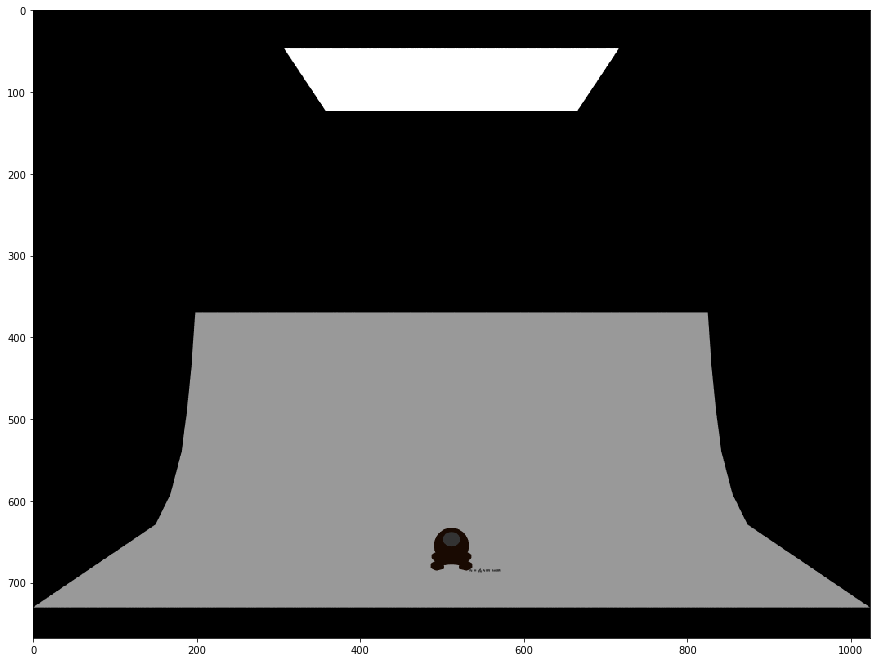

In [8]:
img = pyredner.render_albedo(scene = scene)
# Visualize img
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
%matplotlib inline
plt.figure(figsize = (15,15))
imshow(img)
plt.show()

We see that there is a light source on the top of the scene. The "Knob" we want to look at is a bit far from the camera, let us choose a different camera position. The Knob is `objects[1]` and `objects[4]` in the objects list now, so we use automatic camera placement to focus on these two objects. We also slightly change the camera position.

Scene construction, time: 0.00891 s
Forward pass, time: 0.20050 s


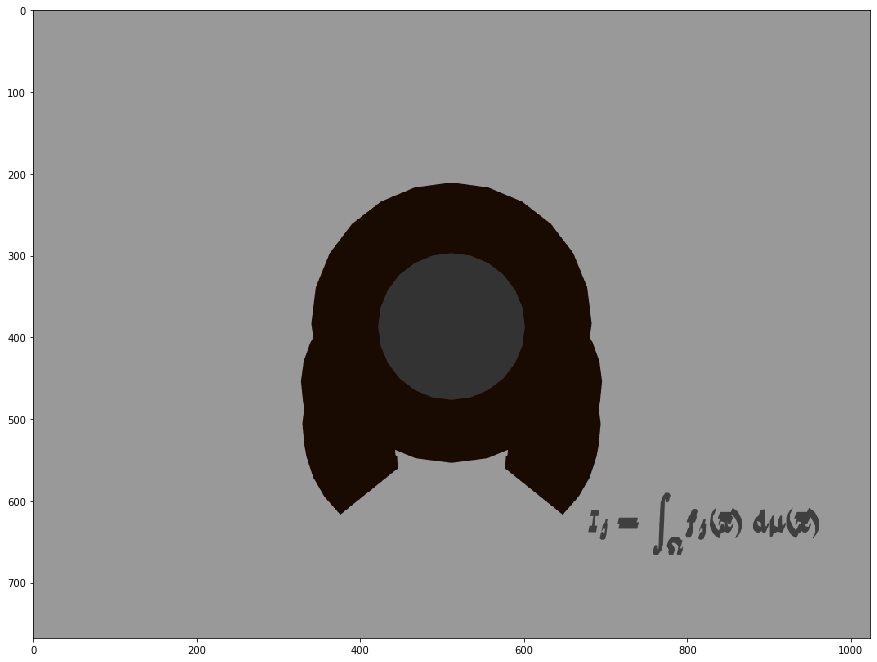

In [9]:
camera = pyredner.automatic_camera_placement([objects[1], objects[4]], resolution=(768, 1024))
# Maker it higher and pull farther from the object.
camera.position = camera.position + tf.constant((0.0, 2.5, -0.5))
scene = pyredner.Scene(camera = camera, objects = objects)
img = pyredner.render_albedo(scene = scene)
# Visualize img
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
%matplotlib inline
plt.figure(figsize = (15,15))
imshow(img)
plt.show()

The materials look a little bit too dark. We can change the reflectance to make them brighter. We will get into the details of redner's material model later in the next tutorial.

In [0]:
objects[4].material.diffuse_reflectance.texels = tf.constant((0.4, 0.16, 0.04))
objects[4].material.specular_reflectance.texels = tf.constant((0.4, 0.4, 0.4))

Scene construction, time: 0.00899 s
Forward pass, time: 0.20014 s


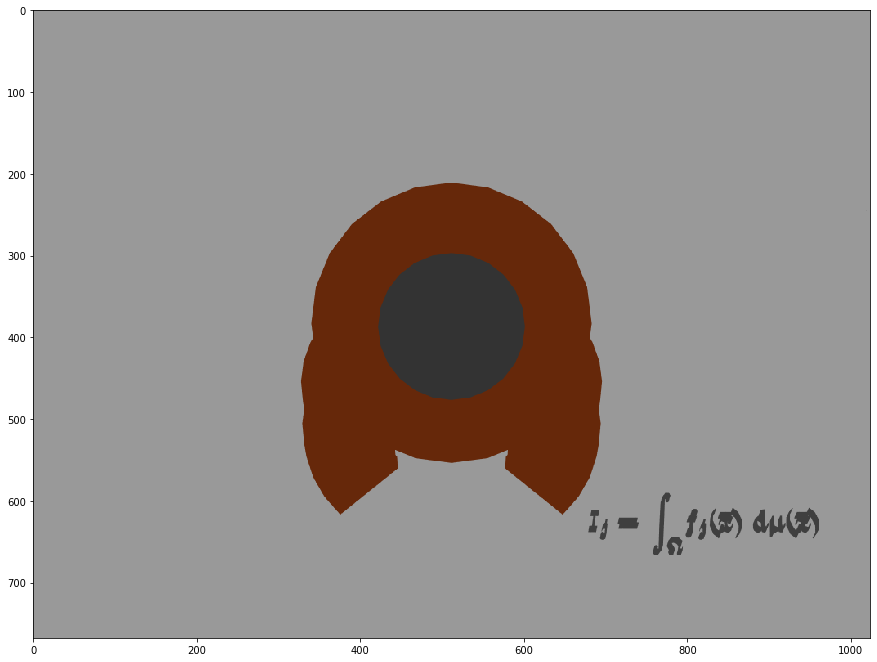

In [11]:
scene = pyredner.Scene(camera = camera, objects = objects)
img = pyredner.render_albedo(scene = scene)
# Visualize img
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
%matplotlib inline
plt.figure(figsize = (15,15))
imshow(img)
plt.show()

Okay. This looks a little bit bland. Now let's use the physically-based rendering mode of redner to render the same image. Before that we want to increase the intensity of the light source so that we can actually see something.

In [0]:
scene.area_lights[0].intensity = tf.constant((15.0, 15.0, 15.0))

Scene construction, time: 0.03975 s


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Forward pass, time: 0.24620 s


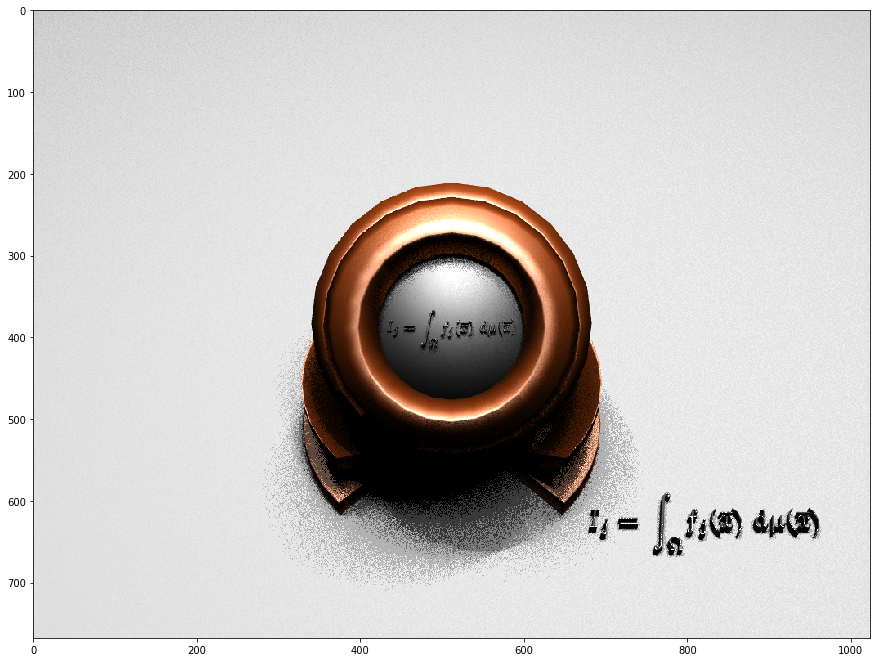

In [13]:
img = pyredner.render_pathtracing(scene = scene)
# Visualize img
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
%matplotlib inline
plt.figure(figsize = (15,15))
imshow(img)
plt.show()

Looks slightly better! Notice the realistic shadow at the bottom of the knob. The image is produced by solving the [rendering equation](https://en.wikipedia.org/wiki/Rendering_equation), which is an integral that requires to be solved using quadrature rules or Monte Carlo sampling. The noise in the image comes from the sampling for estimating the integral. To remove the noise, we can increase the number of sample by setting the `num_samples` argument in `render_pathtracing`.

Scene construction, time: 0.03919 s


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Forward pass, time: 2.35954 s


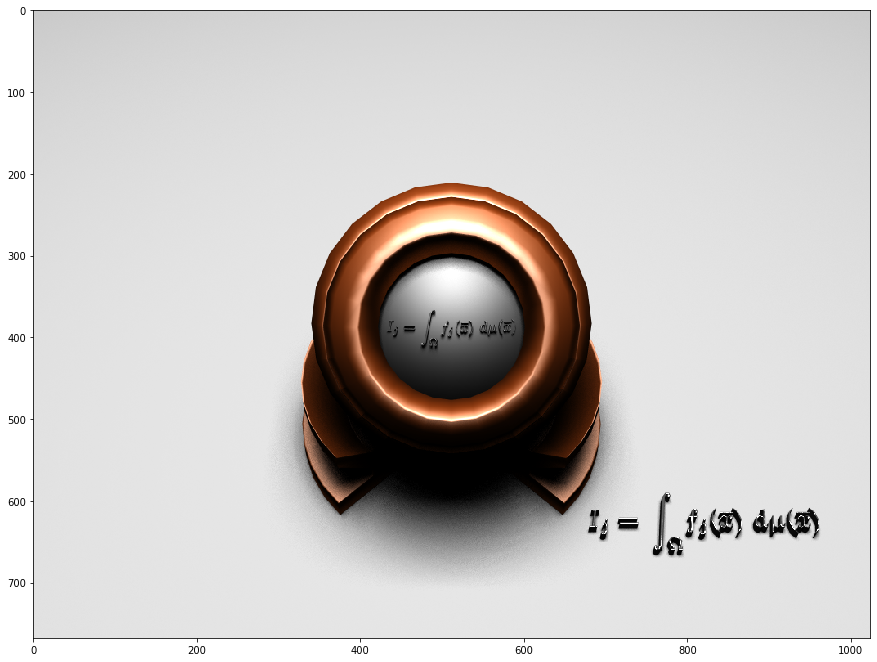

In [14]:
# You can pass an integer or a tuple of two integers to num_samples.
# An integer indicates the same values in the tuple.
# The two numbers in the tuple represents the number of samples used in the forward and backward pass, respectively.
# In general we found that using more samples for the forward pass is more efficient.
img = pyredner.render_pathtracing(scene = scene, num_samples = (64, 4))
# Visualize img
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
%matplotlib inline
plt.figure(figsize = (15,15))
imshow(img)
plt.show()

As you can see the noise is significantly reduced, though the rendering time also becomes longer.

By default, `render_pathtracing` only simulates what we call the "direct lighting". That is, it only simulates the photons that come from the light source and reflect to the camera through one surface. However in reality photons also reflect *between* the surfaces. This is called [global illumination](https://en.wikipedia.org/wiki/Global_illumination) in graphics and redner also supports global illumination. You can turn on global illumination by setting the `max_bounces` parameter in `render_pathtracing` (1 means direct lighting only).

Scene construction, time: 0.04023 s


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Forward pass, time: 4.22091 s


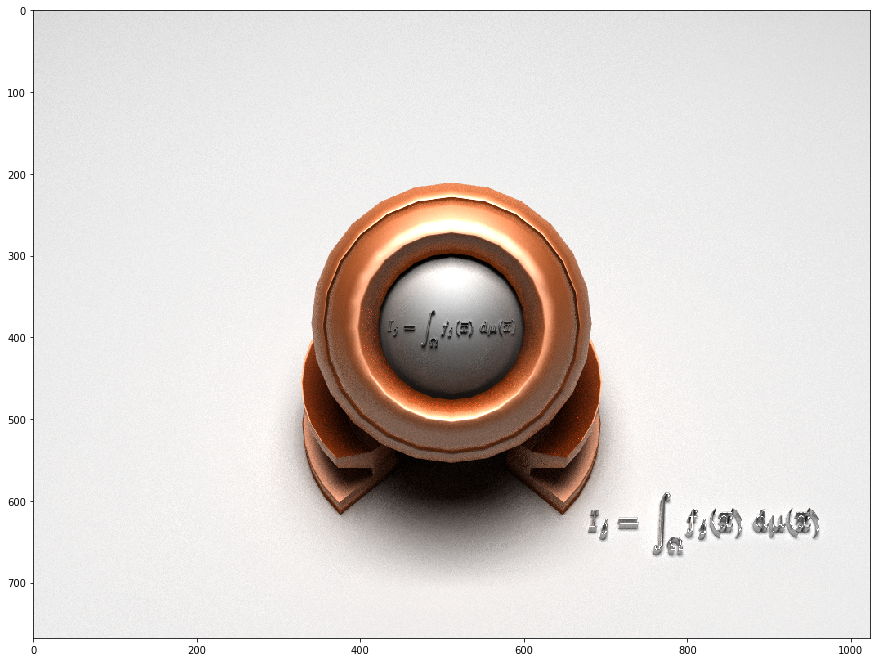

In [15]:
img = pyredner.render_pathtracing(scene = scene, num_samples = (64, 4), max_bounces = 6)
# Visualize img
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
%matplotlib inline
plt.figure(figsize = (15,15))
imshow(img)
plt.show()

Notice how the knob becomes brighter because it receives the photons reflected from the ground.